In [117]:
import numpy as np
import pandas as pd
import json
import netCDF4 as nc
import pyarrow as pa
import pyarrow.parquet as pq
import uuid
import os
from time import time_ns
from time import sleep
from enum import Enum
import matplotlib.pyplot as plt

## I/O speed tests

### Write speed (average of 100)
- As a function of # of rows (5 columns worth, 2e3 - 1e6 points)

### Read (average of 100):
- Metadata read (how long to access one scan’s metadate)
- Column read (how long to access two columns [but check by column])

### Data efficiency
- Storage size as function of rows for 5 columns
- Storing meta experiments in one file vs many (as a function of n experiments)


### Possible solutions
- <span style='color:black'> JSON </span>
- <span style='color:green'> NetCDF </span> and <span style='color:lime'> NetCDF with compression </span>
- <span style='color:magenta'> Parquet </span>
- <span style='color:red'> ORC </span>
- <span style='color:blue'> Avro </span>

In [118]:
# Common functions and values
def make_test_meta():
    test_meta = {'uuid': str(uuid.uuid1()),
                'param1':12,
                'param2':'a_string',
                'param3': np.random.rand()*1e9,
                'param4':['alist','of','strings']}
    return test_meta

def make_test_data(length_of_data):
    test_data = {'time' :(np.array(range(length_of_data))*1e-9).tolist(), # to_list is necessary because json.dumps only takes native python types not numpy types
                 'vals' : np.random.randn(length_of_data).tolist(),
                 'volts': np.random.randn(length_of_data).tolist(), #dummy col names and values to fill columns
                 'dp'   : np.random.randn(length_of_data).tolist(),
                 'dr'   : np.random.randn(length_of_data).tolist()}
    return test_data

def read_data_metrics_file(source):
    with open(source, 'r') as f:
        lines = f.readlines()
    result = {}
    for line in lines:
        subjson = json.loads(line.rstrip(r'\n'))
        for key, item in subjson.items():
            result[key] = item

    return result

def write_data_metrics_to_file(cur_data_metrics, format_type, data_metrics_dict = None,fp = None):
    if fp is None:
        fp = 'data_metrics.json'

    if data_metrics_dict is None:
        data_metrics_dict = read_data_metrics_file(fp)
    
    data_metrics_dict[format_type] = [] # clear any previous test values
    data_metrics_dict[format_type].extend(cur_data_metrics) # Add to the dictionary
    
    then = time_ns()
    with open(fp,'w+') as f:
        to_write = json.dumps(data_metrics_dict)
        f.write(to_write+'\r')
    now = time_ns()
    return (now-then) * 1e-9


def get_col_names():
    return ['time', 'vals', 'volts', 'dp', 'dr']
def round_4(val):
    return round(val, 4)

In [119]:
# Local storage of results
# data_metrics_results = {'JSON': [], 'NetCDF': [], 'NetCDFwComp':[], 'Parquet':[], 'ORC':[], 'Avro':[]}
# res = read_data_metrics_file('data_metrics-Copy1.json')
# data_metrics_results['JSON'] = res['JSON']
# print(data_metrics_results)

# write_data_metrics_to_file([], 'Avro' )
data_metrics_results = read_data_metrics_file('data_metrics.json')
print(data_metrics_results)

{'JSON': [[[0.0228, 0.0316, 0.0423, 0.0583, 0.0819, 0.1111, 0.1517, 0.1633, 0.2523, 0.3453, 0.48, 0.6937, 0.9256, 1.3078, 1.7407, 2.4161, 3.3425, 4.597, 6.1101, 8.1569], [0.1648, 0.2005, 0.2503, 0.3083, 0.3812, 0.4681, 0.5726, 0.7075, 0.8602, 1.0717, 1.3739, 1.7361, 2.1295, 2.632, 3.0239, 3.5835, 4.5111, 5.5744, 7.0406, 8.7409], [1.7488, 1.8979, 2.075, 2.2529, 2.435, 2.6587, 2.9039, 3.1929, 3.4475, 3.7378, 4.1187, 4.4939, 4.8569, 5.3209, 5.7582, 6.2581, 6.8097, 7.4006, 8.0819, 8.7983]], [[197.0216, 272.7706, 379.8494, 525.2011, 730.1939, 1009.9718, 1406.5389, 1950.6996, 2711.9184, 3760.8697, 5222.1068, 7239.8714, 10035.1189, 13955.5805, 19375.3444, 26931.3464, 37339.5057, 51894.5962, 71811.9867, 99758.3575], [1970.1699, 2416.9674, 2971.3966, 3660.9553, 4489.6076, 5511.9966, 6781.0402, 8329.8736, 10219.3781, 12582.8914, 15507.6003, 19030.5228, 23397.5913, 28823.4276, 35386.7526, 43458.4294, 53477.4914, 65736.7253, 80606.9606, 99037.8601], [19702.0759, 21416.955, 23305.0524, 25357.185, 2

## JSON Tests

In [13]:
# JSON data write/read methods 
def make_json_datastore(testdata, meta=None):
    if meta is None:
        test_meta = make_test_meta()
    metadata_as_string = json.dumps(test_meta)
    kepler_json_format = {metadata_as_string: testdata}
    return kepler_json_format

def JSON_write_n_to_file(length_of_data, n_to_write, fp = None):
    if fp is None:
        fp = 'testfile.json'
    if os.path.exists(fp):
        os.unlink(fp)

    then = time_ns()
    with open(fp,'w+') as f:
        for i in range(n_to_write):
            jsonified_data = make_json_datastore(make_test_data(length_of_data)) 
            to_write = json.dumps(jsonified_data)
            f.write(to_write+'\r')
    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size

def JSON_load(source):
    then = time_ns()
    with open(source, 'r') as f:
        lines = f.readlines()
    metajson = {}
    # each line is one experiment and all of its data
    for line in lines:
        subjson = json.loads(line.rstrip(r'\n'))
        # The key is the metadata string and the item is a dictionary of the data
        for key, item in subjson.items():
            metajson[key] = item
    metadata_read = (time_ns() - then)*1e-9
    columns_read = metadata_read # For JSON these are the same

    return metadata_read, columns_read

In [14]:
# small test to check functionality
fp = 'testfile.json'
writetime, filesize = JSON_write_n_to_file(5000, 100, fp)
metadata_read, columns_read = JSON_load('testfile.json')

print(f'time to write: {writetime} s, time to metaread {metadata_read} s and colread is {columns_read} s, size is {filesize} KB')

time to write: 5.5505997 s, time to metaread 2.5374897 s and colread is 2.5374897 s, size is 49230.327 KB


In [2]:

# Data metrics tests JSON
def JSON_metric_tests(data_lengths, n_to_write, fp):
    JSON_w_avg = []
    JSON_fs_avg = [] 
    JSON_meta_r_avg = []
    JSON_col_r_avg = []

    for length_of_data in data_lengths:
        then = time_ns()
        total_w_time = 0
        total_size = 0
        total_metatime = 0
        total_coltime = 0
        tests_per_data_len = 10 if length_of_data >= 500000 else 100
        for i in range(tests_per_data_len):
            # Writing
            wtime, size = JSON_write_n_to_file(length_of_data, n_to_write, fp)
            total_w_time += wtime

            # Size
            total_size += size

            # Reading
            metatime, coltime = JSON_load(fp)
            total_metatime += metatime
            total_coltime += coltime

        JSON_w_avg.append(round((total_w_time / tests_per_data_len), 4))
        JSON_fs_avg.append(round((total_size / tests_per_data_len),4))
        JSON_meta_r_avg.append(round((total_metatime / tests_per_data_len), 4))
        JSON_col_r_avg.append(round((total_coltime / tests_per_data_len),4))

        now = time_ns()
        exptime = (now-then)*1e-9
        print(f'For {length_of_data} rows, write: {JSON_w_avg[-1]} s, readmeta: {JSON_meta_r_avg[-1]}s',
              f' readcol: {JSON_col_r_avg[-1]} s, size: {JSON_fs_avg[-1]} KB, n is: {n_to_write}, totaltime: {exptime} s')
    return JSON_w_avg, JSON_fs_avg, JSON_meta_r_avg, JSON_col_r_avg

In [3]:
# Complete JSON tests across all n
def JSON_metric_tests_across_n(data_lengths_across_n, ns_to_write, fp = None):
    if fp is None:
        fp = 'testfile.json'
    
    JSON_w_avg_across_n = [] # A list write times for each n, 3 writelists, each of len(20)
    JSON_fs_avg_across_n = []
    JSON_meta_r_avg_across_n = []
    JSON_col_r_avg_across_n = []


    start = time_ns()
    for index, n in enumerate(ns_to_write):
        w, fs, meta, col = JSON_metric_tests(data_lengths_across_n[index], n, fp)
        JSON_w_avg_across_n.append(w)
        JSON_fs_avg_across_n.append(fs)
        JSON_meta_r_avg_across_n.append(meta)
        JSON_col_r_avg_across_n.append(col)

    finish = (time_ns() - start)*1e-9
    print(f"Total time for JSON test {finish/60} mins")
    all_metrics = [JSON_w_avg_across_n,JSON_fs_avg_across_n,  JSON_meta_r_avg_across_n, JSON_col_r_avg_across_n]
    return all_metrics


In [133]:
# RUN the entire JSON test
def JSON_data_metrics():
    start_len, end_len, total_data_points = 2000, 1000000, 20
    ns_to_write = [int(x) for x in np.geomspace(1, 100, 3)]
    data_lengths_across_n = []
    for n in ns_to_write:
        data_lengths = [int(x) for x in np.geomspace(start_len, end_len/n, total_data_points)]
        data_lengths_across_n.append(data_lengths)
    
    all_metrics = JSON_metric_tests_across_n(data_lengths_across_n, ns_to_write, 'testfile.json')
    return all_metrics
    
    
JSON_all_metrics = JSON_data_metrics()
print(JSON_all_metrics)
# write_data_metrics_to_file(JSON_all_metrics, 'JSON') #Saving the data


## NetCDF Tests

In [147]:
# NetCDF methods
def NC_make_meta_groupname(meta=None):
    if meta is None:
        test_meta = make_test_meta()
    metadata_as_string = "x"+ json.dumps(test_meta) # first character needs to a be letter 
    return metadata_as_string

def NC_write_n_to_file(length_of_data, n_to_write, fp = None, wargs = None):
    
    if fp is None:
        fp = 'NetCDFTestFile.nc'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()
    comp, = wargs

    with nc.Dataset(fp, "w", format="NETCDF4") as rootgrp:   
        # Add global dimensions to be used in each group
        for col_name in get_col_names():
            rootgrp.createDimension(col_name, length_of_data)

        # Create n groups
        for i in range(n_to_write):
            # create group to hold values of each nth experiment
            testgrp = rootgrp.createGroup(NC_make_meta_groupname())

            test_data = make_test_data(length_of_data)
            # create variables
            for col_name in get_col_names():
                # name = col_name, datatype = f8(np.float64), size = rootgrp.dimensions['x'], also just (col_name)
                if comp:
                    var = testgrp.createVariable(col_name, "f8", (rootgrp.dimensions[col_name],), compression='zlib')
                else:
                    var = testgrp.createVariable(col_name, "f8", (rootgrp.dimensions[col_name],)) 
                var[:] = test_data[col_name]  # fill in the data
     
    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size


def NC_load(source):
    then = time_ns()
    
    with nc.Dataset(source) as rootgrp:
        # get meta data, stored as a dictionary of group names
        metadata = rootgrp.groups.keys()
        metadata_read = (time_ns() - then)*1e-9

        # get coldata
        # then = time_ns()
#         print("no of groups/ns", len(rootgrp.groups.values()))
        for group in rootgrp.groups.values():
            time =  group.variables['time'][:]
            volts = group.variables['volts'][:]
            vals = group.variables['vals'][:]

    columns_read = (time_ns() - then)*1e-9 

    return metadata_read, columns_read


In [149]:
fp = 'NetCDFTestFile.nc'
writetime, filesize = NC_write_n_to_file(2000, 1, fp, wargs = (True,))
metadata_read, columns_read = NC_load(fp)
print(f'time to write: {round_4(writetime)} s, time to metaread {round_4(metadata_read)} s and colread is {round_4(columns_read)} s, size is {round_4(filesize)} KB')

time to write: 0.1317 s, time to metaread 0.0312 s and colread is 0.0312 s, size is 86.638 KB


In [100]:
def NC_metric_tests(data_lengths, n_to_write, comp, fp):
    NC_w_avg = []
    NC_fs_avg = [] 
    NC_meta_r_avg = []
    NC_col_r_avg = []

    for length_of_data in data_lengths:
        then = time_ns()
        total_w_time = 0
        total_size = 0
        total_metatime = 0
        total_coltime = 0
        tests_per_data_len = 10 if length_of_data >= 500000 else 100
        for i in range(tests_per_data_len):
            # Writing
            wtime, size = NC_write_n_to_file(length_of_data, n_to_write, comp, fp)
            total_w_time += wtime

            # Size
            total_size += size

            # Reading
            metatime, coltime = NC_load(fp)
            total_metatime += metatime
            total_coltime += coltime

        NC_w_avg.append(round_4(total_w_time / tests_per_data_len))
        NC_fs_avg.append(round_4(total_size / tests_per_data_len))
        NC_meta_r_avg.append(round_4(total_metatime / tests_per_data_len))
        NC_col_r_avg.append(round_4(total_coltime / tests_per_data_len))

        now = time_ns()
        exptime = round_4((now-then)*1e-9)
        print(f'For {length_of_data} rows, write: {NC_w_avg[-1]} s, readmeta: {NC_meta_r_avg[-1]}s',
              f' readcol: {NC_col_r_avg[-1]} s, size: {NC_fs_avg[-1]} KB, n: {n_to_write}, comp:{comp} totaltime: {exptime} s')
    return NC_w_avg, NC_fs_avg, NC_meta_r_avg, NC_col_r_avg

In [101]:
# Complete NC tests across all n
def NC_metric_tests_across_n(data_lengths_across_n, ns_to_write, fp ):
    if fp is None:
        fp = 'NetCDFTestFile.nc'
    
    NC_w_avg_across_n = [] # A list write times for each n, 3 writelists, each of len(20)
    NC_fs_avg_across_n = []
    NC_meta_r_avg_across_n = []
    NC_col_r_avg_across_n = []


    start = time_ns()
    for index, n in enumerate(ns_to_write):
        w, fs, meta, col = NC_metric_tests(data_lengths_across_n[index], n,comp, fp)
        NC_w_avg_across_n.append(w)
        NC_fs_avg_across_n.append(fs)
        NC_meta_r_avg_across_n.append(meta)
        NC_col_r_avg_across_n.append(col)
 
    finish = (time_ns() - start)*1e-9
    print(f"Total time for NetCDF test {finish/60} mins")
    all_metrics = [NC_w_avg_across_n,NC_fs_avg_across_n,  NC_meta_r_avg_across_n, NC_col_r_avg_across_n]
    return all_metrics

In [150]:
# RUN the entire NC test
def NC_data_metrics():
    fp = 'NetCDFTestFileComp.nc'
    data_lengths_across_n, ns_to_write = setup_test()
    write_function = NC_write_n_to_file
    read_function = NC_load
    comp = True
    wargs = (comp,)
    print(f"Metrics for NetCDF format w comp:{comp}")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function, wargs )
#     all_metrics = NC_metric_tests_across_n(data_lengths_across_n, ns_to_write,comp, 'NetCDFTestFileComp.nc')
#     print(all_metrics)
    return all_metrics


NC_comp_all_metrics = NC_data_metrics()
print(NC_comp_all_metrics)
# print(NC_all_metrics)

# NC_comp_all_metrics = NC_data_metrics()

Metrics for NetCDF format w comp:True
For 2000 rows, write: 0.016 s, readmeta: 0.0098s  readcol: 0.0125 s, size: 86.6934 KB, n: 1, totaltime: 3.0157 s
For 5000 rows, write: 0.0234 s, readmeta: 0.0111s  readcol: 0.0143 s, size: 179.0657 KB, n: 1, totaltime: 3.9127 s
For 2000 rows, write: 0.1089 s, readmeta: 0.0232s  readcol: 0.0405 s, size: 809.3868 KB, n: 10, totaltime: 15.097 s
For 5000 rows, write: 0.211 s, readmeta: 0.0277s  readcol: 0.0536 s, size: 1733.0731 KB, n: 10, totaltime: 26.5321 s
Total time for test 0.8092913300000001 mins
[[[0.0106, 0.0113, 0.012, 0.0119, 0.016, 0.0197, 0.0233, 0.0282, 0.0369, 0.0475, 0.0617, 0.0841, 0.1094, 0.1572, 0.2164, 0.2896, 0.374, 0.5012, 0.6683, 0.9355], [0.077, 0.0832, 0.0907, 0.1004, 0.1123, 0.1242, 0.1409, 0.1609, 0.1796, 0.2075, 0.2372, 0.2741, 0.3113, 0.3548, 0.4183, 0.5167, 0.6315, 0.7916, 0.9616, 1.1693], [0.8035, 0.8297, 0.8335, 0.8386, 0.8727, 0.9135, 0.9379, 0.9781, 1.0279, 1.0602, 1.1224, 1.1622, 1.2147, 1.2672, 1.333, 1.3883, 1.4877,

In [116]:
# print(NC_all_metrics)
# write_data_metrics_to_file(NC_all_metrics, 'NetCDF') #Saving the data

# print(NC_comp_all_metrics)
# write_data_metrics_to_file(NC_comp_all_metrics, 'NetCDFwComp') #Saving the data

## Parquet tests

In [122]:
# Parquet methods
def PQ_make_meta_groups(n_to_write):
    metadata_rows = {}
    for i in range(n_to_write):
        test_meta = json.dumps(make_test_meta())
        metadata_rows[test_meta] = i
    return json.dumps(metadata_rows)


def PQ_create_schema_w_meta(n_to_write):
    df = pd.DataFrame(make_test_data(1)) # Small dataframe to get pandas schema
    table = pa.Table.from_pandas(df, preserve_index=False)
    row_group_mappings = PQ_make_meta_groups(n_to_write)
    custom_metadata = {'row_group_meta': row_group_mappings}
    existing_metadata = table.schema.metadata
    merged_metadata = { **custom_metadata, **existing_metadata }
    table = table.replace_schema_metadata(merged_metadata)
    return table.schema

def PQ_write_n_to_file(length_of_data, n_to_write, fp = None):
    
    if fp is None:
        fp = 'PQTestFile.parquet'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()
    
    my_schema = PQ_create_schema_w_meta(n_to_write)
    with pq.ParquetWriter(fp, my_schema) as writer:
        for i in range(n_to_write):
            df = pd.DataFrame(make_test_data(length_of_data))
            table = pa.Table.from_pandas(df, preserve_index=False)
            writer.write_table(table, row_group_size = length_of_data)

    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size


def PQ_load(source):
    then = time_ns()

    # Accessing meta
    metadata_pq = pq.read_metadata(source)
    meta = metadata_pq.metadata[b'row_group_meta']
    row_group_mappings = json.loads(meta)
    metadata_read = (time_ns() - then)*1e-9

    # Accessing columns
    with pq.ParquetFile(source) as parquet_file:
        for row_num in row_group_mappings.values():
            table = parquet_file.read_row_group(row_num, columns=['time', 'vals','volts']).to_pandas()

    columns_read = (time_ns() - then)*1e-9 

    return metadata_read, columns_read

In [123]:
# small test to check functionality
fp = 'PQTestFile.parquet'
writetime, filesize = PQ_write_n_to_file(20000, 5, fp)
metadata_read, columns_read = PQ_load(fp)
# print(writetime, filesize)

print(f'time to write: {round_4(writetime)} s, time to metaread {round_4(metadata_read)} s and colread is {round_4(columns_read)} s, size is {round_4(filesize)} KB')

time to write: 0.2478 s, time to metaread 0.0158 s and colread is 0.0334 s, size is 4911.616 KB


In [146]:
# RUN the entire NC test
def PQ_data_metrics():
    fp = 'PQTestFile.parquet'
    data_lengths_across_n, ns_to_write = setup_test()

    write_function = PQ_write_n_to_file
    read_function = PQ_load
    print("Metrics for Parquet format")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function )

    return all_metrics


PQ_all_metrics = PQ_data_metrics()
print(PQ_all_metrics)


Metrics for Parquet format
For 2000 rows, write: 0.0154 s, readmeta: 0.0089s  readcol: 0.0125 s, size: 94.9812 KB, n: 1, totaltime: 2.8664 s
For 5000 rows, write: 0.0227 s, readmeta: 0.0059s  readcol: 0.0101 s, size: 238.9241 KB, n: 1, totaltime: 3.3927 s
For 2000 rows, write: 0.1 s, readmeta: 0.0076s  readcol: 0.029 s, size: 928.9966 KB, n: 10, totaltime: 13.0306 s
For 5000 rows, write: 0.1622 s, readmeta: 0.0088s  readcol: 0.0304 s, size: 2368.5971 KB, n: 10, totaltime: 19.3676 s
Total time for test 0.6442887033333334 mins
[[[0.0154, 0.0227], [0.1, 0.1622]], [[94.9812, 238.9241], [928.9966, 2368.5971]], [[0.0089, 0.0059], [0.0076, 0.0088]], [[0.0125, 0.0101], [0.029, 0.0304]]]


In [145]:
def setup_test():
    start_len, end_len, total_data_points = 2000, 1000000, 20
    test_lens = [2000, 5000]
    ns_to_write = [int(x) for x in np.geomspace(1, 10, 2)]
    data_lengths_across_n = []
    for n in ns_to_write:
        data_lengths = [int(x) for x in np.geomspace(start_len, end_len/n, total_data_points)]
        data_lengths_across_n.append(test_lens)
    return data_lengths_across_n, ns_to_write

In [131]:
def metric_tests(data_lengths, n_to_write, fp, write_function, read_function, wargs = None, rargs=None):
    w_avg = []
    fs_avg = [] 
    meta_r_avg = []
    col_r_avg = []

    for length_of_data in data_lengths:
        then = time_ns()
        total_w_time = 0
        total_size = 0
        total_metatime = 0
        total_coltime = 0
        tests_per_data_len = 10 if length_of_data >= 500000 else 100
        for i in range(tests_per_data_len):
            # Writing
            if wargs is None:
                wtime, size = write_function(length_of_data, n_to_write, fp)
            else:
                wtime, size = write_function(length_of_data, n_to_write, fp, wargs)
                
            total_w_time += wtime

            # Size
            total_size += size

            # Reading
            if rargs is None:
                metatime, coltime = read_function(fp)
            else:
                metatime, coltime = read_function(fp, rargs)
            total_metatime += metatime
            total_coltime += coltime

        w_avg.append(round_4(total_w_time / tests_per_data_len))
        fs_avg.append(round_4(total_size / tests_per_data_len))
        meta_r_avg.append(round_4(total_metatime / tests_per_data_len))
        col_r_avg.append(round_4(total_coltime / tests_per_data_len))

        now = time_ns()
        exptime = round_4((now-then)*1e-9)
        print(f'For {length_of_data} rows, write: {w_avg[-1]} s, readmeta: {meta_r_avg[-1]}s',
              f' readcol: {col_r_avg[-1]} s, size: {fs_avg[-1]} KB, n: {n_to_write}, totaltime: {exptime} s')
    return w_avg, fs_avg, meta_r_avg, col_r_avg

In [132]:
# Complete tests across all n
def metric_tests_across_n(data_lengths_across_n, ns_to_write, fp, write_function, read_function, wargs = None, rargs=None):
    
    w_avg_across_n = [] # A list write times for each n, 3 writelists, each of len(20)
    fs_avg_across_n = []
    meta_r_avg_across_n = []
    col_r_avg_across_n = []


    start = time_ns()
    for index, n in enumerate(ns_to_write):
        w, fs, meta, col = metric_tests(data_lengths_across_n[index], n, fp,  write_function, read_function, wargs, rargs )
        w_avg_across_n.append(w)
        fs_avg_across_n.append(fs)
        meta_r_avg_across_n.append(meta)
        col_r_avg_across_n.append(col)
 
    finish = (time_ns() - start)*1e-9
    print(f"Total time for test {finish/60} mins")
    all_metrics = [w_avg_across_n,fs_avg_across_n,  meta_r_avg_across_n, col_r_avg_across_n]
    return all_metrics

## I/O speed tests results

### Graphs 1 : Write speed 
- Write speed across different formats as a function of # of rows, each graph with a different n

### Graphs 2 : Storage size
- Size across different formats as a function of # of rows, each graph with a different n

### Graphs 3 :  Reading speed
- Metadata read over # of rows, across different ns
- Column read over # of rows, across different ns

### Possible formats
- <span style='color:black'> JSON </span>
- <span style='color:green'> NetCDF </span> and <span style='color:lime'> NetCDF with compression </span>
- <span style='color:magenta'> Parquet </span>
- <span style='color:red'> ORC </span>
- <span style='color:blue'> Avro </span>

In [109]:
# Graphs set up
results = read_data_metrics_file('data_metrics.json')
markers = ['o', '*', '^'] # for n = 1, 10, 100
format_colors = ['k', 'g','lime' ,'m', 'r', 'b'] # as per ['JSON', 'NetCDF','NetCDFwComp' ,'Parquet', 'ORC', 'Avro' ]
start_len, end_len, total_data_points = 2000, 1000000, 20
ns_to_write = [int(x) for x in np.geomspace(1, 100, 3)]
data_lengths_across_n = []
for n in ns_to_write:
    data_lengths = [int(x) for x in np.geomspace(start_len, end_len/n, total_data_points)]
    data_lengths_across_n.append(data_lengths)
class DataMetricsPos(Enum):
    Writing = 0
    Filesize = 1
    Metaread = 2
    Colread = 3

C:\Users\megan\AppData\Local\Temp\ipykernel_19224\2030418027.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, plot_num)


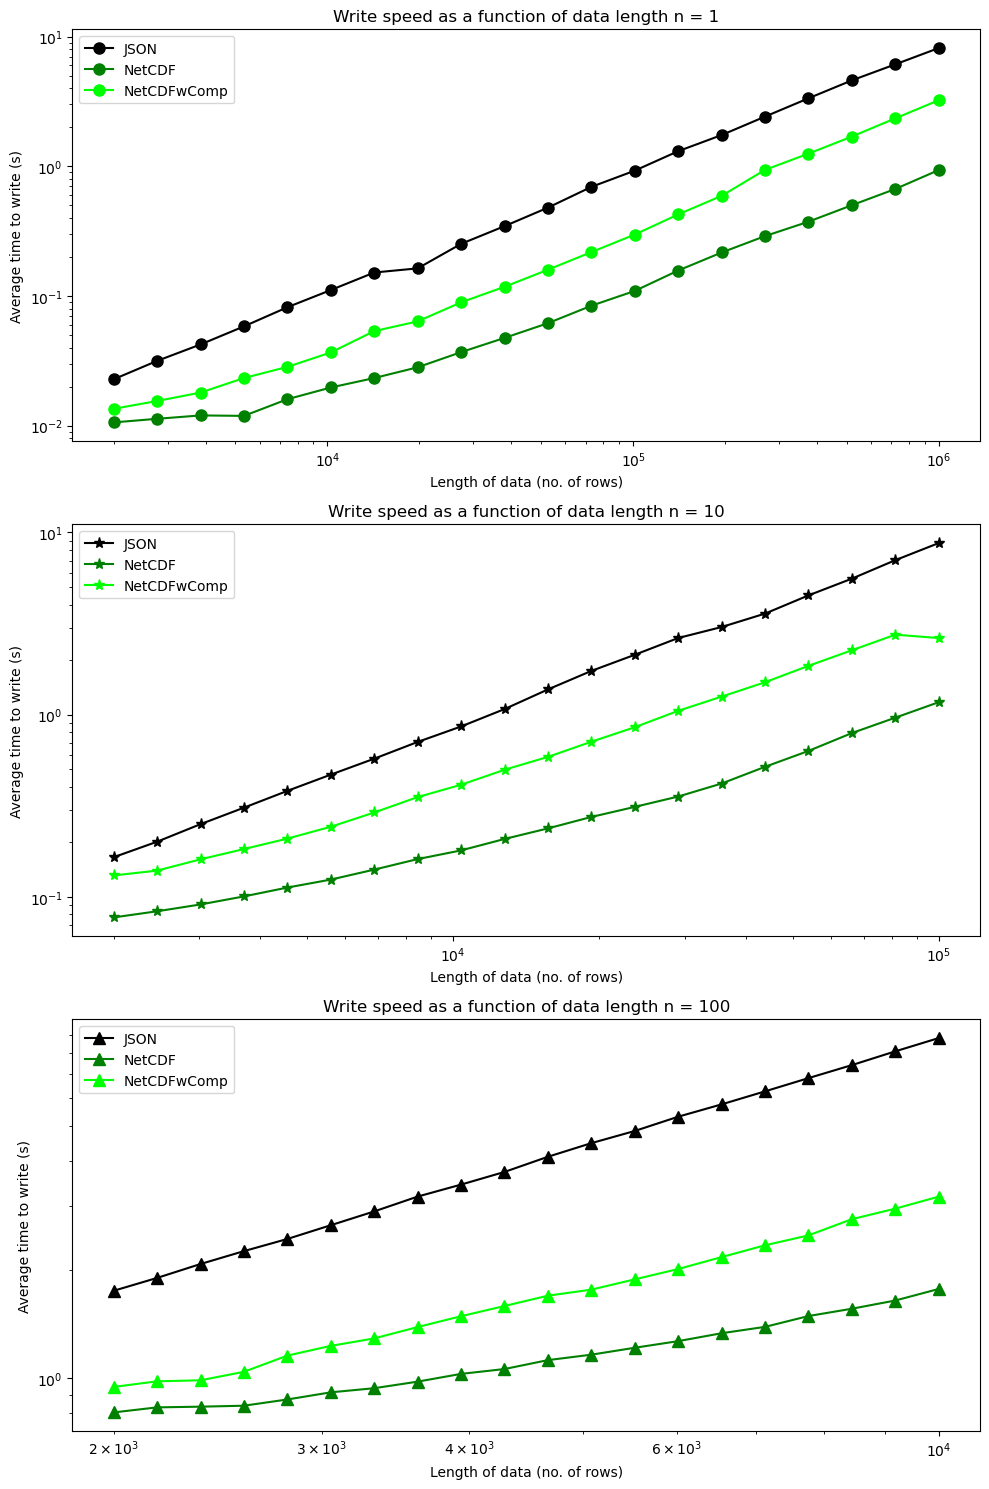

In [111]:
# Writing speed results
plt.subplots(figsize=(10, 15))

for (n_index, n), mark in zip(enumerate(ns_to_write), markers):
    plot_num = n_index + 1
    plt.subplot(3, 1, plot_num)
    plt.title(f'Write speed as a function of data length n = {n}')
    plt.xlabel('Length of data (no. of rows)')
    plt.ylabel('Average time to write (s)')
    for i, formats in enumerate(results.keys()):
        if(results[formats]):
            plt.loglog(data_lengths_across_n[n_index], results[formats][DataMetricsPos['Writing'].value][n_index], 
                     color = format_colors[i], marker = mark, markersize =8, label = formats )
    plt.legend()
plt.tight_layout() # To make the plots fit nicely
plt.show()

C:\Users\megan\AppData\Local\Temp\ipykernel_19224\1750796680.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, plot_num)


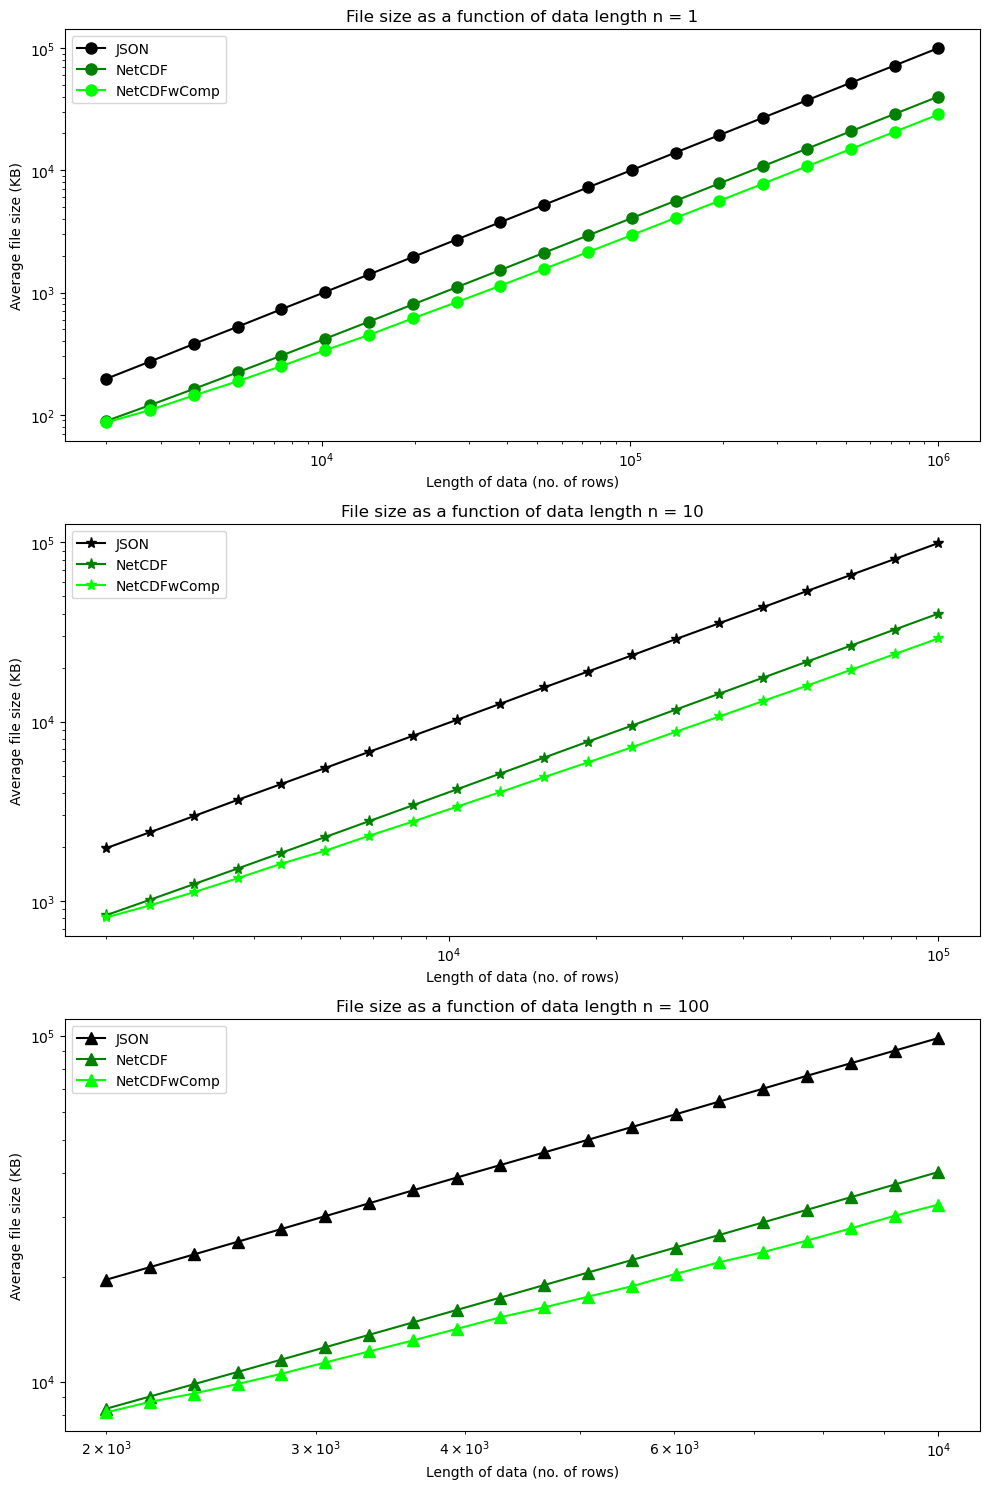

In [110]:
# Data size speed results
plt.subplots(figsize=(10, 15))

for (n_index, n), mark in zip(enumerate(ns_to_write), markers):
    plot_num = n_index + 1
    plt.subplot(3, 1, plot_num)
    plt.title(f'File size as a function of data length n = {n}')
    plt.xlabel('Length of data (no. of rows)')
    plt.ylabel('Average file size (KB)')
    plt.ticklabel_format(style='plain')
    for i, formats in enumerate(results.keys()):
         if(results[formats]):
            plt.loglog(data_lengths_across_n[n_index], results[formats][DataMetricsPos['Filesize'].value][n_index], 
                     color = format_colors[i], marker = mark, markersize =8, label = formats )
    plt.legend()
plt.tight_layout() # To make the plots fit nicely
plt.show()

C:\Users\megan\AppData\Local\Temp\ipykernel_19224\599513258.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, plot_num)


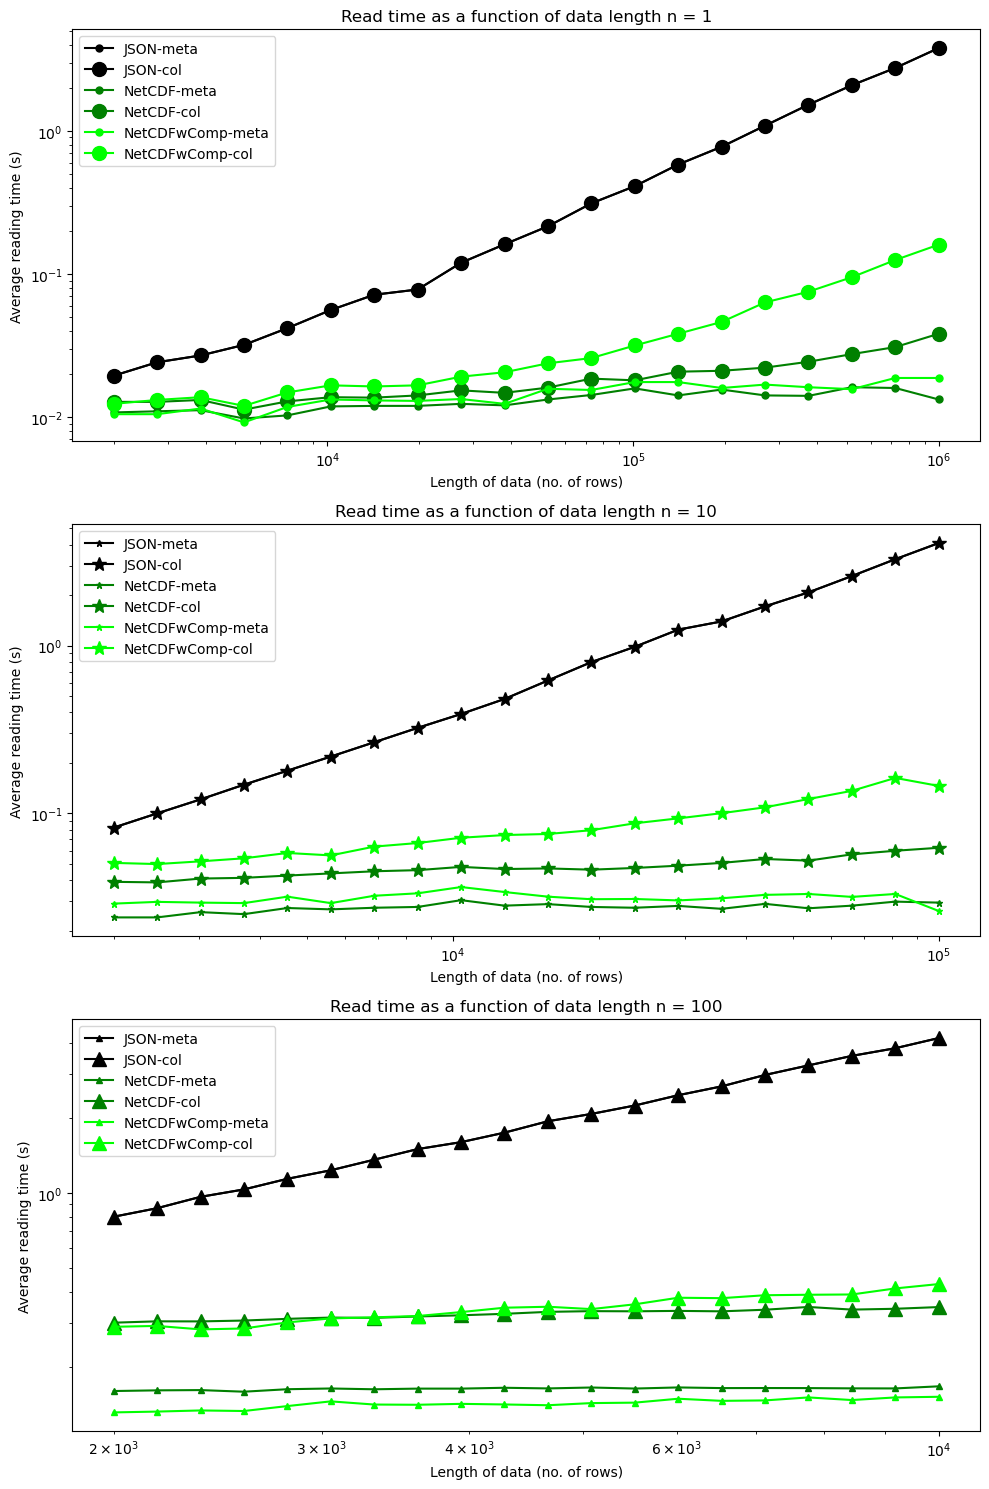

In [112]:
# Reading speed results
plt.subplots(figsize=(10, 15))
for (n_index, n), mark in zip(enumerate(ns_to_write), markers):
    plot_num = n_index + 1
    plt.subplot(3, 1, plot_num)
    plt.title(f'Read time as a function of data length n = {n}')
    plt.xlabel('Length of data (no. of rows)')
    plt.ylabel('Average reading time (s)')
    plt.ticklabel_format(style='plain')
    for i, formats in enumerate(results.keys()):
         if(results[formats]):
            plt.loglog(data_lengths_across_n[n_index], results[formats][DataMetricsPos['Metaread'].value][n_index], 
                     color = format_colors[i], marker = mark, markersize =5, label = str(formats + "-meta"))
            plt.loglog(data_lengths_across_n[n_index], results[formats][DataMetricsPos['Colread'].value][n_index], 
                     color = format_colors[i], marker = mark, markersize =10, label = str(formats + "-col") )
    plt.legend()     
    
plt.tight_layout() # To make the plots fit nicely
plt.show()

In [60]:
'''
Scratch SPACE
To write in a csv file sometime
Final stats on JSON

For 2000 rows, write: 0.0228 s, readmeta: 0.0195s  readcol: 0.0195 s, size: 197.0216 KB, n is: 1, totaltime: 4.3572147 s
For 2773 rows, write: 0.0316 s, readmeta: 0.0242s  readcol: 0.0242 s, size: 272.7706 KB, n is: 1, totaltime: 5.768533000000001 s
For 3847 rows, write: 0.0423 s, readmeta: 0.027s  readcol: 0.027 s, size: 379.8494 KB, n is: 1, totaltime: 7.0440776000000005 s
For 5335 rows, write: 0.0583 s, readmeta: 0.032s  readcol: 0.032 s, size: 525.2011 KB, n is: 1, totaltime: 9.355527700000001 s
For 7400 rows, write: 0.0819 s, readmeta: 0.0419s  readcol: 0.0419 s, size: 730.1939 KB, n is: 1, totaltime: 12.576327500000001 s
For 10263 rows, write: 0.1111 s, readmeta: 0.0561s  readcol: 0.0561 s, size: 1009.9718 KB, n is: 1, totaltime: 17.0485005 s
For 14234 rows, write: 0.1517 s, readmeta: 0.0717s  readcol: 0.0717 s, size: 1406.5389 KB, n is: 1, totaltime: 22.793997800000003 s
For 19741 rows, write: 0.1633 s, readmeta: 0.078s  readcol: 0.078 s, size: 1950.6996 KB, n is: 1, totaltime: 24.572873100000002 s
For 27380 rows, write: 0.2523 s, readmeta: 0.1199s  readcol: 0.1199 s, size: 2711.9184 KB, n is: 1, totaltime: 37.9541009 s
For 37974 rows, write: 0.3453 s, readmeta: 0.1613s  readcol: 0.1613 s, size: 3760.8697 KB, n is: 1, totaltime: 51.4672713 s
For 52667 rows, write: 0.48 s, readmeta: 0.2156s  readcol: 0.2156 s, size: 5222.1068 KB, n is: 1, totaltime: 70.4502045 s
For 73045 rows, write: 0.6937 s, readmeta: 0.3117s  readcol: 0.3117 s, size: 7239.8714 KB, n is: 1, totaltime: 101.83781520000001 s
For 101307 rows, write: 0.9256 s, readmeta: 0.4111s  readcol: 0.4111 s, size: 10035.1189 KB, n is: 1, totaltime: 135.3306798 s
For 140505 rows, write: 1.3078 s, readmeta: 0.5823s  readcol: 0.5823 s, size: 13955.5805 KB, n is: 1, totaltime: 191.65020360000003 s
For 194869 rows, write: 1.7407 s, readmeta: 0.7747s  readcol: 0.7747 s, size: 19375.3444 KB, n is: 1, totaltime: 255.2966284 s
For 270268 rows, write: 2.4161 s, readmeta: 1.0881s  readcol: 1.0881 s, size: 26931.3464 KB, n is: 1, totaltime: 355.6105448 s
For 374840 rows, write: 3.3425 s, readmeta: 1.5237s  readcol: 1.5237 s, size: 37339.5057 KB, n is: 1, totaltime: 493.8382745 s
For 519873 rows, write: 4.597 s, readmeta: 2.085s  readcol: 2.085 s, size: 51894.5962 KB, n is: 1, totaltime: 67.83944890000001 s
For 721022 rows, write: 6.1101 s, readmeta: 2.7523s  readcol: 2.7523 s, size: 71811.9867 KB, n is: 1, totaltime: 89.9723252 s
For 1000000 rows, write: 8.1569 s, readmeta: 3.7895s  readcol: 3.7895 s, size: 99758.3575 KB, n is: 1, totaltime: 121.3473029 s
For 2000 rows, write: 0.1648 s, readmeta: 0.0823s  readcol: 0.0823 s, size: 1970.1699 KB, n is: 10, totaltime: 25.1224187 s
For 2457 rows, write: 0.2005 s, readmeta: 0.1s  readcol: 0.1 s, size: 2416.9674 KB, n is: 10, totaltime: 30.4058245 s
For 3019 rows, write: 0.2503 s, readmeta: 0.1212s  readcol: 0.1212 s, size: 2971.3966 KB, n is: 10, totaltime: 37.6110916 s
For 3709 rows, write: 0.3083 s, readmeta: 0.1483s  readcol: 0.1483 s, size: 3660.9553 KB, n is: 10, totaltime: 46.177767200000005 s
For 4557 rows, write: 0.3812 s, readmeta: 0.1797s  readcol: 0.1797 s, size: 4489.6076 KB, n is: 10, totaltime: 56.551755400000005 s
For 5599 rows, write: 0.4681 s, readmeta: 0.2181s  readcol: 0.2181 s, size: 5511.9966 KB, n is: 10, totaltime: 69.24352 s
For 6879 rows, write: 0.5726 s, readmeta: 0.2655s  readcol: 0.2655 s, size: 6781.0402 KB, n is: 10, totaltime: 84.166589 s
For 8452 rows, write: 0.7075 s, readmeta: 0.3234s  readcol: 0.3234 s, size: 8329.8736 KB, n is: 10, totaltime: 103.71501740000001 s
For 10384 rows, write: 0.8602 s, readmeta: 0.3912s  readcol: 0.3912 s, size: 10219.3781 KB, n is: 10, totaltime: 125.9793592 s
For 12758 rows, write: 1.0717 s, readmeta: 0.4806s  readcol: 0.4806 s, size: 12582.8914 KB, n is: 10, totaltime: 156.36754380000002 s
For 15675 rows, write: 1.3739 s, readmeta: 0.6195s  readcol: 0.6195 s, size: 15507.6003 KB, n is: 10, totaltime: 200.9658134 s
For 19259 rows, write: 1.7361 s, readmeta: 0.7972s  readcol: 0.7972 s, size: 19030.5228 KB, n is: 10, totaltime: 255.3121049 s
For 23662 rows, write: 2.1295 s, readmeta: 0.9836s  readcol: 0.9836 s, size: 23397.5913 KB, n is: 10, totaltime: 313.6243379 s
For 29072 rows, write: 2.632 s, readmeta: 1.2444s  readcol: 1.2444 s, size: 28823.4276 KB, n is: 10, totaltime: 390.5387617 s
For 35719 rows, write: 3.0239 s, readmeta: 1.3932s  readcol: 1.3932 s, size: 35386.7526 KB, n is: 10, totaltime: 445.1912209 s
For 43885 rows, write: 3.5835 s, readmeta: 1.7128s  readcol: 1.7128 s, size: 43458.4294 KB, n is: 10, totaltime: 534.0426351 s
For 53918 rows, write: 4.5111 s, readmeta: 2.0754s  readcol: 2.0754 s, size: 53477.4914 KB, n is: 10, totaltime: 664.2496062 s
For 66246 rows, write: 5.5744 s, readmeta: 2.5972s  readcol: 2.5972 s, size: 65736.7253 KB, n is: 10, totaltime: 823.9552094000001 s
For 81391 rows, write: 7.0406 s, readmeta: 3.2728s  readcol: 3.2728 s, size: 80606.9606 KB, n is: 10, totaltime: 1040.0856518 s
For 100000 rows, write: 8.7409 s, readmeta: 4.0842s  readcol: 4.0842 s, size: 99037.8601 KB, n is: 10, totaltime: 1293.0936565000002 s
For 2000 rows, write: 1.7488 s, readmeta: 0.8019s  readcol: 0.8019 s, size: 19702.0759 KB, n is: 100, totaltime: 256.6246181 s
For 2176 rows, write: 1.8979 s, readmeta: 0.8674s  readcol: 0.8674 s, size: 21416.955 KB, n is: 100, totaltime: 278.31876980000004 s
For 2369 rows, write: 2.075 s, readmeta: 0.9637s  readcol: 0.9637 s, size: 23305.0524 KB, n is: 100, totaltime: 305.89963620000003 s
For 2578 rows, write: 2.2529 s, readmeta: 1.0319s  readcol: 1.0319 s, size: 25357.185 KB, n is: 100, totaltime: 330.6753306 s
For 2806 rows, write: 2.435 s, readmeta: 1.1384s  readcol: 1.1384 s, size: 27605.0158 KB, n is: 100, totaltime: 359.77038710000005 s
For 3054 rows, write: 2.6587 s, readmeta: 1.2319s  readcol: 1.2319 s, size: 30062.8976 KB, n is: 100, totaltime: 391.54046370000003 s
For 3324 rows, write: 2.9039 s, readmeta: 1.3585s  readcol: 1.3585 s, size: 32749.0207 KB, n is: 100, totaltime: 429.13455580000004 s
For 3618 rows, write: 3.1929 s, readmeta: 1.4986s  readcol: 1.4986 s, size: 35693.4479 KB, n is: 100, totaltime: 472.225053 s
For 3938 rows, write: 3.4475 s, readmeta: 1.598s  readcol: 1.598 s, size: 38868.9824 KB, n is: 100, totaltime: 507.78776330000005 s
For 4286 rows, write: 3.7378 s, readmeta: 1.7447s  readcol: 1.7447 s, size: 42253.47 KB, n is: 100, totaltime: 551.8859838000001 s
For 4665 rows, write: 4.1187 s, readmeta: 1.9384s  readcol: 1.9384 s, size: 45951.8841 KB, n is: 100, totaltime: 609.6710563 s
For 5078 rows, write: 4.4939 s, readmeta: 2.0745s  readcol: 2.0745 s, size: 49997.6855 KB, n is: 100, totaltime: 661.2358505000001 s
For 5526 rows, write: 4.8569 s, readmeta: 2.242s  readcol: 2.242 s, size: 54401.6568 KB, n is: 100, totaltime: 714.8216114 s
For 6015 rows, write: 5.3209 s, readmeta: 2.4662s  readcol: 2.4662 s, size: 59228.6581 KB, n is: 100, totaltime: 784.2883382 s
For 6547 rows, write: 5.7582 s, readmeta: 2.6765s  readcol: 2.6765 s, size: 64504.6575 KB, n is: 100, totaltime: 849.8458457 s
For 7126 rows, write: 6.2581 s, readmeta: 2.975s  readcol: 2.975 s, size: 70276.587 KB, n is: 100, totaltime: 930.2658649000001 s
For 7755 rows, write: 6.8097 s, readmeta: 3.2492s  readcol: 3.2492 s, size: 76535.2642 KB, n is: 100, totaltime: 1013.2022938 s
For 8441 rows, write: 7.4006 s, readmeta: 3.5485s  readcol: 3.5485 s, size: 83190.9198 KB, n is: 100, totaltime: 1102.8081382 s
For 9187 rows, write: 8.0819 s, readmeta: 3.8087s  readcol: 3.8087 s, size: 90453.4845 KB, n is: 100, totaltime: 1197.5147866 s
For 10000 rows, write: 8.7983 s, readmeta: 4.1844s  readcol: 4.1844 s, size: 98393.3307 KB, n is: 100, totaltime: 1308.0058513000001 s
Total time for JSON test 363.80056558 mins

#NETCDF
For 2000 rows, write: 0.0106 s, readmeta: 0.0108s  readcol: 0.0128 s, size: 89.0003 KB, n is: 1, totaltime: 2.4298 s
For 2773 rows, write: 0.0113 s, readmeta: 0.011s  readcol: 0.0128 s, size: 119.9202 KB, n is: 1, totaltime: 2.5473 s
For 3847 rows, write: 0.012 s, readmeta: 0.0112s  readcol: 0.0132 s, size: 162.8802 KB, n is: 1, totaltime: 2.6879 s
For 5335 rows, write: 0.0119 s, readmeta: 0.0098s  readcol: 0.0113 s, size: 222.4001 KB, n is: 1, totaltime: 2.4759 s
For 7400 rows, write: 0.016 s, readmeta: 0.0103s  readcol: 0.0129 s, size: 305.0002 KB, n is: 1, totaltime: 3.1146 s
For 10263 rows, write: 0.0197 s, readmeta: 0.0119s  readcol: 0.0138 s, size: 419.5201 KB, n is: 1, totaltime: 3.5625 s
For 14234 rows, write: 0.0233 s, readmeta: 0.012s  readcol: 0.0137 s, size: 578.3603 KB, n is: 1, totaltime: 3.9643 s
For 19741 rows, write: 0.0282 s, readmeta: 0.012s  readcol: 0.0142 s, size: 798.6402 KB, n is: 1, totaltime: 4.4989 s
For 27380 rows, write: 0.0369 s, readmeta: 0.0124s  readcol: 0.0154 s, size: 1104.2002 KB, n is: 1, totaltime: 5.455 s
For 37974 rows, write: 0.0475 s, readmeta: 0.0121s  readcol: 0.0148 s, size: 1527.9601 KB, n is: 1, totaltime: 6.9143 s
For 52667 rows, write: 0.0617 s, readmeta: 0.0133s  readcol: 0.0161 s, size: 2115.6801 KB, n is: 1, totaltime: 8.2997 s
For 73045 rows, write: 0.0841 s, readmeta: 0.0143s  readcol: 0.0186 s, size: 2930.8002 KB, n is: 1, totaltime: 10.9859 s
For 101307 rows, write: 0.1094 s, readmeta: 0.0159s  readcol: 0.0181 s, size: 4061.2801 KB, n is: 1, totaltime: 13.4838 s
For 140505 rows, write: 0.1572 s, readmeta: 0.0142s  readcol: 0.0208 s, size: 5629.2001 KB, n is: 1, totaltime: 18.9638 s
For 194869 rows, write: 0.2164 s, readmeta: 0.0156s  readcol: 0.0211 s, size: 7803.7602 KB, n is: 1, totaltime: 25.5392 s
For 270268 rows, write: 0.2896 s, readmeta: 0.0142s  readcol: 0.0222 s, size: 10819.7201 KB, n is: 1, totaltime: 33.7487 s
For 374840 rows, write: 0.374 s, readmeta: 0.0141s  readcol: 0.0244 s, size: 15002.6002 KB, n is: 1, totaltime: 43.3548 s
For 519873 rows, write: 0.5012 s, readmeta: 0.0162s  readcol: 0.0276 s, size: 20803.9203 KB, n is: 1, totaltime: 5.7751 s
For 721022 rows, write: 0.6683 s, readmeta: 0.016s  readcol: 0.0309 s, size: 28849.8804 KB, n is: 1, totaltime: 7.675 s
For 1000000 rows, write: 0.9355 s, readmeta: 0.0133s  readcol: 0.0383 s, size: 40009.0002 KB, n is: 1, totaltime: 10.771 s
For 2000 rows, write: 0.077 s, readmeta: 0.024s  readcol: 0.0391 s, size: 832.7748 KB, n is: 10, totaltime: 11.7244 s
For 2457 rows, write: 0.0832 s, readmeta: 0.024s  readcol: 0.0388 s, size: 1015.5822 KB, n is: 10, totaltime: 12.3648 s
For 3019 rows, write: 0.0907 s, readmeta: 0.0258s  readcol: 0.0409 s, size: 1240.3728 KB, n is: 10, totaltime: 13.2586 s
For 3709 rows, write: 0.1004 s, readmeta: 0.0251s  readcol: 0.0413 s, size: 1516.3694 KB, n is: 10, totaltime: 14.2864 s
For 4557 rows, write: 0.1123 s, readmeta: 0.0273s  readcol: 0.0426 s, size: 1855.5748 KB, n is: 10, totaltime: 15.6825 s
For 5599 rows, write: 0.1242 s, readmeta: 0.0268s  readcol: 0.0439 s, size: 2272.3804 KB, n is: 10, totaltime: 17.0076 s
For 6879 rows, write: 0.1409 s, readmeta: 0.0274s  readcol: 0.0452 s, size: 2784.3858 KB, n is: 10, totaltime: 18.8175 s
For 8452 rows, write: 0.1609 s, readmeta: 0.0277s  readcol: 0.0459 s, size: 3413.5859 KB, n is: 10, totaltime: 20.8866 s
For 10384 rows, write: 0.1796 s, readmeta: 0.0304s  readcol: 0.048 s, size: 4186.3802 KB, n is: 10, totaltime: 22.9831 s
For 12758 rows, write: 0.2075 s, readmeta: 0.0282s  readcol: 0.0466 s, size: 5135.9729 KB, n is: 10, totaltime: 25.5919 s
For 15675 rows, write: 0.2372 s, readmeta: 0.0288s  readcol: 0.047 s, size: 6302.7858 KB, n is: 10, totaltime: 28.5268 s
For 19259 rows, write: 0.2741 s, readmeta: 0.0277s  readcol: 0.0462 s, size: 7736.3802 KB, n is: 10, totaltime: 32.47 s
For 23662 rows, write: 0.3113 s, readmeta: 0.0274s  readcol: 0.0473 s, size: 9497.5729 KB, n is: 10, totaltime: 36.3571 s
For 29072 rows, write: 0.3548 s, readmeta: 0.0281s  readcol: 0.0488 s, size: 11661.5841 KB, n is: 10, totaltime: 40.825 s
For 35719 rows, write: 0.4183 s, readmeta: 0.027s  readcol: 0.0507 s, size: 14320.3748 KB, n is: 10, totaltime: 47.5131 s
For 43885 rows, write: 0.5167 s, readmeta: 0.0289s  readcol: 0.0535 s, size: 17586.7857 KB, n is: 10, totaltime: 57.5853 s
For 53918 rows, write: 0.6315 s, readmeta: 0.0272s  readcol: 0.0523 s, size: 21599.9951 KB, n is: 10, totaltime: 69.2304 s
For 66246 rows, write: 0.7916 s, readmeta: 0.0282s  readcol: 0.057 s, size: 26531.1823 KB, n is: 10, totaltime: 85.6775 s
For 81391 rows, write: 0.9616 s, readmeta: 0.0298s  readcol: 0.0599 s, size: 32589.1766 KB, n is: 10, totaltime: 103.1001 s
For 100000 rows, write: 1.1693 s, readmeta: 0.0294s  readcol: 0.0624 s, size: 40032.7875 KB, n is: 10, totaltime: 124.3986 s
For 2000 rows, write: 0.8035 s, readmeta: 0.16s  readcol: 0.301 s, size: 8350.4656 KB, n is: 100, totaltime: 110.6318 s
For 2176 rows, write: 0.8297 s, readmeta: 0.161s  readcol: 0.3048 s, size: 9054.4557 KB, n is: 100, totaltime: 113.7212 s
For 2369 rows, write: 0.8335 s, readmeta: 0.1614s  readcol: 0.3046 s, size: 9826.4149 KB, n is: 100, totaltime: 114.166 s
For 2578 rows, write: 0.8386 s, readmeta: 0.159s  readcol: 0.307 s, size: 10662.4459 KB, n is: 100, totaltime: 114.8953 s
For 2806 rows, write: 0.8727 s, readmeta: 0.1627s  readcol: 0.3119 s, size: 11574.4645 KB, n is: 100, totaltime: 118.7125 s
For 3054 rows, write: 0.9135 s, readmeta: 0.1638s  readcol: 0.3156 s, size: 12566.4715 KB, n is: 100, totaltime: 123.1776 s
For 3324 rows, write: 0.9379 s, readmeta: 0.1626s  readcol: 0.3147 s, size: 13646.4173 KB, n is: 100, totaltime: 125.4882 s
For 3618 rows, write: 0.9781 s, readmeta: 0.1636s  readcol: 0.3188 s, size: 14822.4039 KB, n is: 100, totaltime: 130.0269 s
For 3938 rows, write: 1.0279 s, readmeta: 0.1636s  readcol: 0.3223 s, size: 16102.4127 KB, n is: 100, totaltime: 135.4602 s
For 4286 rows, write: 1.0602 s, readmeta: 0.1649s  readcol: 0.3267 s, size: 17494.4077 KB, n is: 100, totaltime: 139.0105 s
For 4665 rows, write: 1.1224 s, readmeta: 0.1639s  readcol: 0.3327 s, size: 19010.4589 KB, n is: 100, totaltime: 145.7934 s
For 5078 rows, write: 1.1622 s, readmeta: 0.1653s  readcol: 0.3349 s, size: 20662.4678 KB, n is: 100, totaltime: 150.1244 s
For 5526 rows, write: 1.2147 s, readmeta: 0.1637s  readcol: 0.3344 s, size: 22454.4657 KB, n is: 100, totaltime: 155.271 s
For 6015 rows, write: 1.2672 s, readmeta: 0.1654s  readcol: 0.3357 s, size: 24410.4626 KB, n is: 100, totaltime: 160.733 s
For 6547 rows, write: 1.333 s, readmeta: 0.1644s  readcol: 0.3343 s, size: 26538.4229 KB, n is: 100, totaltime: 167.3637 s
For 7126 rows, write: 1.3883 s, readmeta: 0.1645s  readcol: 0.3393 s, size: 28854.4853 KB, n is: 100, totaltime: 173.1964 s
For 7755 rows, write: 1.4877 s, readmeta: 0.1644s  readcol: 0.3481 s, size: 31370.4352 KB, n is: 100, totaltime: 184.125 s
For 8441 rows, write: 1.5591 s, readmeta: 0.164s  readcol: 0.3397 s, size: 34114.404 KB, n is: 100, totaltime: 190.4608 s
For 9187 rows, write: 1.643 s, readmeta: 0.1639s  readcol: 0.3423 s, size: 37098.4411 KB, n is: 100, totaltime: 199.2113 s
For 10000 rows, write: 1.7692 s, readmeta: 0.1671s  readcol: 0.3478 s, size: 40350.519 KB, n is: 100, totaltime: 212.2245 s
Total time for NetCDF test 66.305477065 mins


For 2000 rows, write: 0.0131 s, readmeta: 0.0103s  readcol: 0.0129 s, size: 86.6941 KB, n: 1, comp:True totaltime: 2.659 s
For 5000 rows, write: 0.0228 s, readmeta: 0.0115s  readcol: 0.0154 s, size: 179.0595 KB, n: 1, comp:True totaltime: 3.8814 s
For 10000 rows, write: 0.0393 s, readmeta: 0.0112s  readcol: 0.0148 s, size: 329.855 KB, n: 1, comp:True totaltime: 5.5745 s
For 2000 rows, write: 0.1098 s, readmeta: 0.0239s  readcol: 0.043 s, size: 809.4339 KB, n: 10, comp:True totaltime: 15.351 s
For 5000 rows, write: 0.1719 s, readmeta: 0.0241s  readcol: 0.0456 s, size: 1733.1263 KB, n: 10, comp:True totaltime: 21.8899 s
For 10000 rows, write: 0.3083 s, readmeta: 0.0294s  readcol: 0.0573 s, size: 3241.0364 KB, n: 10, comp:True totaltime: 36.7249 s
For 2000 rows, write: 1.0943 s, readmeta: 0.1583s  readcol: 0.3393 s, size: 8147.576 KB, n: 100, comp:True totaltime: 143.5419 s
For 5000 rows, write: 1.8093 s, readmeta: 0.1479s  readcol: 0.3634 s, size: 17383.9596 KB, n: 100, comp:True totaltime: 217.5897 s
For 10000 rows, write: 3.7359 s, readmeta: 0.174s  readcol: 0.4957 s, size: 32463.7156 KB, n: 100, comp:True totaltime: 423.7472 s
Total time for NetCDF comp test 14.516268371666667 mins


For 2000 rows, write: 0.0141 s, readmeta: 0.0066s  readcol: 0.0099 s, size: 94.9811 KB, n: 1, totaltime: 2.4924 s
For 5000 rows, write: 0.0199 s, readmeta: 0.0072s  readcol: 0.0117 s, size: 238.9241 KB, n: 1, totaltime: 3.2334 s
For 10000 rows, write: 0.0411 s, readmeta: 0.0093s  readcol: 0.0127 s, size: 484.0352 KB, n: 1, totaltime: 5.4433 s
For 2000 rows, write: 0.1056 s, readmeta: 0.0084s  readcol: 0.0318 s, size: 928.9964 KB, n: 10, totaltime: 13.8215 s
For 5000 rows, write: 0.1885 s, readmeta: 0.0077s  readcol: 0.0326 s, size: 2368.598 KB, n: 10, totaltime: 22.233 s
For 10000 rows, write: 0.305 s, readmeta: 0.0077s  readcol: 0.0332 s, size: 4819.769 KB, n: 10, totaltime: 34.0054 s
For 2000 rows, write: 0.9884 s, readmeta: 0.012s  readcol: 0.2159 s, size: 9272.1749 KB, n: 100, totaltime: 120.7717 s
For 5000 rows, write: 1.6921 s, readmeta: 0.0125s  readcol: 0.2375 s, size: 23666.6927 KB, n: 100, totaltime: 193.4032 s
For 10000 rows, write: 2.906 s, readmeta: 0.0105s  readcol: 0.261 s, size: 48177.7641 KB, n: 100, totaltime: 317.518 s
Total time for Parquet test 11.882031711666666 mins
'''
x=5

In [ ]:

 #The real set of data lengths
# test_lens = [2000, 5000, 10000]
# test_lens = [2000, 5000, 10000, 50000, 100000, 250000, 500000, 750000, 900000, 950000, 1000000]
fp = 'testfile.json'
# Reading tests JSON
JSON_meta_r_avg, JSON_meta_r_test_avg = [], []
JSON_col_r_avg, JSON_col_r_test_avg = [], []
for length_of_data in test_lens:
    write_n_to_file(length_of_data, 1, fp) # write the data
    then = time_ns()
    meta_total_time = 0
    col_total_time = 0
    tests_per_data_len = 10 if length_of_data >= 500000 else 100
    for i in range(tests_per_data_len):
        metatime, coltime = JSON_load(fp)
        meta_total_time += metatime
        col_total_time += coltime
    JSON_meta_r_test_avg.append(round((meta_total_time / tests_per_data_len), 4))
    JSON_col_r_test_avg.append(round((col_total_time / tests_per_data_len),4))
    now = time_ns()
    exptime = (now-then)*1e-9
    print(f'Time for {length_of_data} rows, is {exptime} s ({tests_per_data_len} times) avg meta is {JSON_meta_r_test_avg[-1]}s,',
           f'avg col is {JSON_col_r_test_avg[-1]} s')

In [ ]:

def PQ_metric_tests(data_lengths, n_to_write, fp):
    PQ_w_avg = []
    PQ_fs_avg = [] 
    PQ_meta_r_avg = []
    PQ_col_r_avg = []

    for length_of_data in data_lengths:
        then = time_ns()
        total_w_time = 0
        total_size = 0
        total_metatime = 0
        total_coltime = 0
        tests_per_data_len = 10 if length_of_data >= 500000 else 100
        for i in range(tests_per_data_len):
            # Writing
            wtime, size = PQ_write_n_to_file(length_of_data, n_to_write, fp)
            total_w_time += wtime

            # Size
            total_size += size

            # Reading
            metatime, coltime = PQ_load(fp)
            total_metatime += metatime
            total_coltime += coltime

        PQ_w_avg.append(round_4(total_w_time / tests_per_data_len))
        PQ_fs_avg.append(round_4(total_size / tests_per_data_len))
        PQ_meta_r_avg.append(round_4(total_metatime / tests_per_data_len))
        PQ_col_r_avg.append(round_4(total_coltime / tests_per_data_len))

        now = time_ns()
        exptime = round_4((now-then)*1e-9)
        print(f'For {length_of_data} rows, write: {PQ_w_avg[-1]} s, readmeta: {PQ_meta_r_avg[-1]}s',
              f' readcol: {PQ_col_r_avg[-1]} s, size: {PQ_fs_avg[-1]} KB, n: {n_to_write}, totaltime: {exptime} s')
    return PQ_w_avg, PQ_fs_avg, PQ_meta_r_avg, PQ_col_r_avg

# Complete NC tests across all n
def PQ_metric_tests_across_n(data_lengths_across_n, ns_to_write, fp = None):
    if fp is None:
        fp = 'PQTestFile.parquet'
    
    PQ_w_avg_across_n = [] # A list write times for each n, 3 writelists, each of len(20)
    PQ_fs_avg_across_n = []
    PQ_meta_r_avg_across_n = []
    PQ_col_r_avg_across_n = []


    start = time_ns()
    for index, n in enumerate(ns_to_write):
        w, fs, meta, col = PQ_metric_tests(data_lengths_across_n[index], n, fp)
        PQ_w_avg_across_n.append(w)
        PQ_fs_avg_across_n.append(fs)
        PQ_meta_r_avg_across_n.append(meta)
        PQ_col_r_avg_across_n.append(col)
 
    finish = (time_ns() - start)*1e-9
    print(f"Total time for Parquet test {finish/60} mins")
    all_metrics = [PQ_w_avg_across_n,PQ_fs_avg_across_n,  PQ_meta_r_avg_across_n, PQ_col_r_avg_across_n]
    return all_metrics